<a href="https://colab.research.google.com/github/SHASHIKATSHEGOKAR/Cohort-Analysis/blob/main/Copy_of_Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import missingno as msno
from textwrap import wrap

Data loading and cleaning



In [ ]:
# Loading dataset
df = pd.read_excel('transcations data.xlsx')
# View data
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


Checking and working with missing value



In [ ]:
# Inspect missing values in the dataset
print(df.isnull().values.sum())
# Replace the ' 's with NaN
df = df.replace(" ",np.NaN)
# Impute the missing values with mean imputation
df = df.fillna(df.mean())
# Count the number of NaNs in the dataset to verify
print(df.isnull().values.sum())

1542
788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
print(df.info())
for col in df.columns:
    # Check if the column is of object type
    if df[col].dtypes == 'object':
        # Impute with the most frequent value
        df[col] = df[col].fillna(df[col].value_counts().index[0])
# Count the number of NaNs in the dataset and print the counts to verify
print(df.isnull().values.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             20000 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            20000 non-null  float64       
 12  product_first_sold_date  20000 n

Assigned the cohorts and calculated the monthly offset


In [ ]:
# A function that will parse the date Time based cohort:  1 day of month
def get_month(x): return dt.datetime(x.year, x.month, 1)
# Create transaction_date column based on month and store in TransactionMonth
df['TransactionMonth'] = df['transaction_date'].apply(get_month)
# Grouping by customer_id and select the InvoiceMonth value
grouping = df.groupby('customer_id')['TransactionMonth']
# Assigning a minimum InvoiceMonth value to the dataset
df['CohortMonth'] = grouping.transform('min')
# printing top 5 rows
print(df.head())

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date TransactionMonth  \
0       71.49     

Calculating time offset in Month as Cohort Index


In [ ]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
# Getting the integers for date parts from the `InvoiceDay` column
transcation_year, transaction_month, _ = get_date_int(df, 'TransactionMonth')
# Getting the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [ ]:
#  Get the  difference in years
years_diff = transcation_year - cohort_year
# Calculate difference in months
months_diff = transaction_month - cohort_month
""" Extract the difference in months from all previous values
 "+1" in addeded at the end so that first month is marked as 1 instead of 0 for easier interpretation.
 """
df['CohortIndex'] = years_diff * 12 + months_diff  + 1
print(df.head(5))

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date TransactionMonth  \
0       71.49     

In [ ]:
# Counting daily active user from each chort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
# Counting number of unique customer Id's falling in each group of CohortMonth and CohortIndex
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
 # Assigning column names to the dataframe created above
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'customer_id')
# Printing top 5 rows of Dataframe
cohort_data.head()

,CohortMonth,CohortIndex,customer_id
0,2017-01-01,1,1354
1,2017-01-01,2,486
2,2017-01-01,3,508
3,2017-01-01,4,509
4,2017-01-01,5,502


Calculate business metrics: Retention rate


In [ ]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
# Coverting the retention rate into percentage and Rounding off.
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,100.0,35.9,37.5,37.6,37.1,35.7,38.3,39.1,36.9,39.2,36.7,38.1
2017-02-01,100.0,40.6,37.2,39.1,36.0,37.2,38.5,35.1,41.1,38.5,37.0,NaN
2017-03-01,100.0,34.5,36.0,34.5,37.6,38.0,35.5,43.8,39.0,37.4,NaN,NaN
2017-04-01,100.0,33.0,36.0,45.5,42.6,36.0,42.3,37.5,39.3,NaN,NaN,NaN
2017-05-01,100.0,40.5,38.6,41.4,33.8,35.2,34.8,38.6,NaN,NaN,NaN,NaN
2017-06-01,100.0,36.9,36.1,38.5,37.7,37.7,43.4,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,33.8,37.7,41.6,48.1,31.2,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,37.3,41.2,33.3,25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,30.4,30.4,39.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Calculate Retention rate per Month Index

cohort_size = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_size, axis = 0)

retention = retention.round(3)*100

retention.index = retention.index.strftime('%Y-%m')

Visualizing the retention rate
With Heatmap

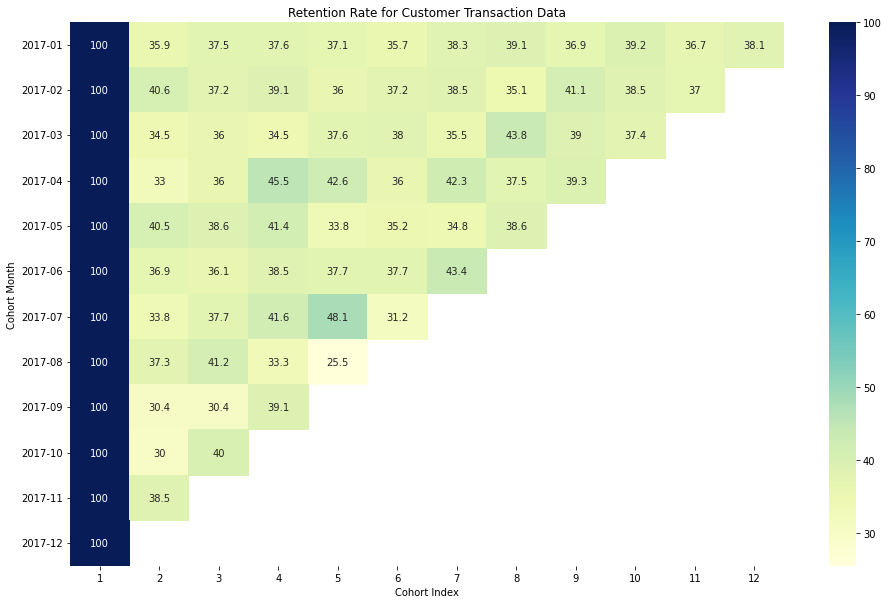

In [ ]:
#Plotting Heatmap for Retention Table

plt.figure(figsize = (16,10))

plt.title('Retention Rate for Customer Transaction Data')

sns.heatmap(retention, annot = True, cmap="YlGnBu", fmt='g')

plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')
plt.yticks(rotation = '360')

plt.show()